# Co-occurrence Matrices

Using balanced title data. Intended for use with [GloVe](https://nlp.stanford.edu/projects/glove/) to improve balanced title embedding predictions.

# Imports and Setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [ ]:
import arxiv_vixra_models as avm

Copy data to cwd for speed.

In [ ]:
SUBDIR = '/data/data_splits/'
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
!cp '{train_data_path}' .
train_data_df = pd.read_feather(train_data_file_name)
text_file_name = 'concatenated_balanced_normalized_train_title.txt'
title_tokens_file_name = 'balanced_title_normalized_vocab.feather'
abstract_tokens_file_name = 'large_abstract_normalized_vocab.feather'
for file_name in (text_file_name,
                  title_tokens_file_name,
                  abstract_tokens_file_name):
    !cp '{FOLDERNAME + SUBDIR + file_name}' .
with open(text_file_name, 'r') as f:
    text = f.read().strip()
title_tokens_df = pd.read_feather(title_tokens_file_name)
abstract_tokens_df = pd.read_feather(abstract_tokens_file_name)

Create the mappings from words to indices, recalling that 0 and 1 are reserved for padding and `<UNK>`, respectively.

In [ ]:
title_word_to_idx = dict(zip(title_tokens_df.word.values, np.arange(2, len(title_tokens_df) + 2)))
title_word_to_idx['<PAD>'] = 0
title_word_to_idx['<UNK>'] = 1
title_idx_to_word = {val: key for key, val in title_word_to_idx.items()}

Computing specs.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

Not connected to a GPU
Memory
--------------------------------------------------
 Your runtime has 54.8 gigabytes of available RAM
 

CPU
--------------------------------------------------
 CPU Processors: 8


Useful to know the mean word counts for setting context window sizes.

In [ ]:
print(f"Mean word count:", {train_data_df['title'].str.count('\s').mean() + 1})

Mean word count: {9.985772010699447}


Can compute co-occurrence matrices as in:

In [ ]:
balanced_title_co_matrix_generator = avm.CoMatrixBuilder(text=text,
                                                                      word_to_idx=title_word_to_idx,
                                                                      context_window=2,
                                                                      batch_size=2**16,
                                                                      device=torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu'),
                                                                      num_workers=NUM_PROCESSORS, 
                                                                      pin_memory=IS_CUDA_AVAILABLE,
                                                                      non_blocking=IS_CUDA_AVAILABLE,
                                                                      glove_window_weighting=True,
                                                                      check_normalization=False)
balanced_title_co_matrix_generator.generate_co_matrix()
balanced_title_co_matrix = balanced_title_co_matrix_generator.get_sparse_co_matrix(save_path=FOLDERNAME + SUBDIR+ f'balanced_title_co_matrix_context_{balanced_title_co_matrix_generator.context_window}.pt')

Encoding text...
...done!
Generating co-occurrence matrix...
90% complete. Approx.  remaining.
...done!


Or load the computed results from Drive:

In [ ]:
balanced_title_cooccurrence_matrix = torch.load(FOLDERNAME + f'/data/data_splits/balanced_title_co_matrix_context_2.pt')
# Read speeds are an order of magnitude faster if dense:
balanced_title_cooccurrence_matrix = balanced_title_cooccurrence_matrix.to_dense()

# Inspection

Make sure the results seem reasonable.

In [ ]:
def topk_cooccurrences(word,
                       co_matrix=balanced_title_cooccurrence_matrix,
                       word_to_idx=title_word_to_idx,
                       idx_to_word=title_idx_to_word,
                       k=10):
    """Returns the top k words which co-occur with the provided word.
    """
    assert word in word_to_idx, f'{word} does not exist in word_to_idx'
    word_idx = word_to_idx[word]
    co_matrix_row = co_matrix[word_idx]
    topk_indices = co_matrix_row.topk(k).indices
    topk_words = [idx_to_word[idx.item()] for idx in topk_indices]
    return topk_words

def topk_cooccurrences_df(words,
                          co_matrix=balanced_title_cooccurrence_matrix,
                          word_to_idx=title_word_to_idx,
                          idx_to_word=title_idx_to_word,
                          k=10):
    """Return a df with the topk co-occurrences for a given word or iterable of words
    from the provided co_matrix. Helper for visualizing topk_cooccurrences.
    """
    if isinstance(words, str):
        words = [words]
    df_dict = {}
    for word in words:
        df_dict[word + '_topk'] = topk_cooccurrences(word,
                                                           co_matrix,
                                                           word_to_idx,
                                                           idx_to_word,  
                                                           k=k)
    return pd.DataFrame(df_dict)

Various examples:

In [ ]:
topk_cooccurrences_df(('quantum', '$', 'einstein', 'smarandache', 'renormalization'), k=20)

,quantum_topk,$_topk,einstein_topk,smarandache_topk,renormalization_topk
0,the,$,-,the,the
1,of,\,the,.,group
2,.,",",of,-,of
3,a,the,bose,of,.
4,<UNK>,_,.,",",-
5,in,<UNK>,in,<UNK>,<UNK>
6,",",.,",",a,a
7,-,-,<UNK>,and,","
8,and,},',function,and
9,to,of,equations,(,(


As in the GloVe paper, let us compute various ratios of co-occurrence probabilities

In [ ]:
def cooccurrence_prob(co_matrix,
                     word1, 
                     word2,
                     word_to_idx=title_word_to_idx):
    """Returns (a rough estimate of) the probability p12 of drawing word2 amongst
    all words which appear in the context of word1.
    """
    word1_idx, word2_idx = word_to_idx[word1], word_to_idx[word2]

    # Using the GloVe notation for Xij, Xi:
    x12 = co_matrix[word1_idx, word2_idx]
    x1 = co_matrix[word1_idx].sum()
    p12 = x12 / x1
    return p12

def cooccurrence_prob_ratio(co_matrix,
                           word1, 
                           word2,
                           word3,
                           word_to_idx=title_word_to_idx,
                           epsilon=1e-10):
    """Returns the ratio of probabilities p13/p23 as computed from
    cooccurrence_prob. A small number is added to the denominator to avoid
    divide-by-zero errors.
    """
    p13 = cooccurrence_prob(co_matrix,
                           word1,
                           word3,
                           word_to_idx)
    p23 = cooccurrence_prob(co_matrix,
                           word2,
                           word3,
                           word_to_idx)
    prob_ratio = p13 / (p23 + epsilon)
    return prob_ratio

It's clear from plots that these ratios reflect one's expectations for how related various words are to each other:

In [ ]:
def get_word_count(word, tokens_df):
    word_count = tokens_df[tokens_df['word'] == word]['count'].values.item()
    return word_count

def log_prob_ratios_plotter(co_matrix,
                            word1,
                            word2,
                            aux_words,
                            tokens_df,
                            save_path=None,
                            suptitle=True):
    """
    Plotting helper for log-probability ratios.
    """
    def co_probs_list(word):
        return [cooccurrence_prob(co_matrix, word, aux) for aux in aux_words]
    
    # Add gross word counts to the aux_words index.
    aux_words_index = [aux + f' ({get_word_count(aux, tokens_df)})' for aux in aux_words]
    print()

    probs_dict = {}
    for word in (word1, word2):
        probs_dict[word] = [cooccurrence_prob(co_matrix, word, aux).item() for aux in aux_words]
    probs_df = pd.DataFrame(probs_dict, index=aux_words_index)
    probs_df['log_ratio'] = np.log(probs_df[word1] / probs_df[word2])
    probs_df['diff'] = probs_df[word1] - probs_df[word2]

    def log_label(word1, word2):
        return f'$\\log \\left( \\frac{{P_{{{word1}\\ x}} }}{{ \\ P_{{{word2}\\ x}} }}\\right)$'
    
    def diff_label(word1, word2):
        return f'$P_{{{word1}\\ x}} -  P_{{{word2}\\ x}} $'

    fig, (ax_top, ax_bottom) = plt.subplots(2, figsize=(15, 16))
    probs_df['log_ratio'].sort_values(ascending=True).plot.barh(label=log_label(word1, word2),
                                                                fontsize=16,
                                                                legend=True,
                                                                ax=ax_top)
    probs_df['diff'].sort_values(ascending=True).plot.barh(label=diff_label(word1, word2),
                                                           fontsize=16,
                                                           legend=True,
                                                           ax=ax_bottom)
    ax_top.legend(fontsize=28)
    ax_top.set_title('log probability-ratios', 
                     fontsize=24
                     )
    ax_bottom.legend(fontsize=28)
    ax_bottom.set_title('probability differences',
                        fontsize=24
                        )
    plt.tight_layout()
    if suptitle:
        word1_count = get_word_count(word1, tokens_df)
        word2_count = get_word_count(word2, tokens_df)
        sup_text = f'{word1} ({word1_count}) & {word2} ({word2_count}) probabilities'
        fig.suptitle(sup_text, fontsize=30)
        fig.subplots_adjust(top=.9)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

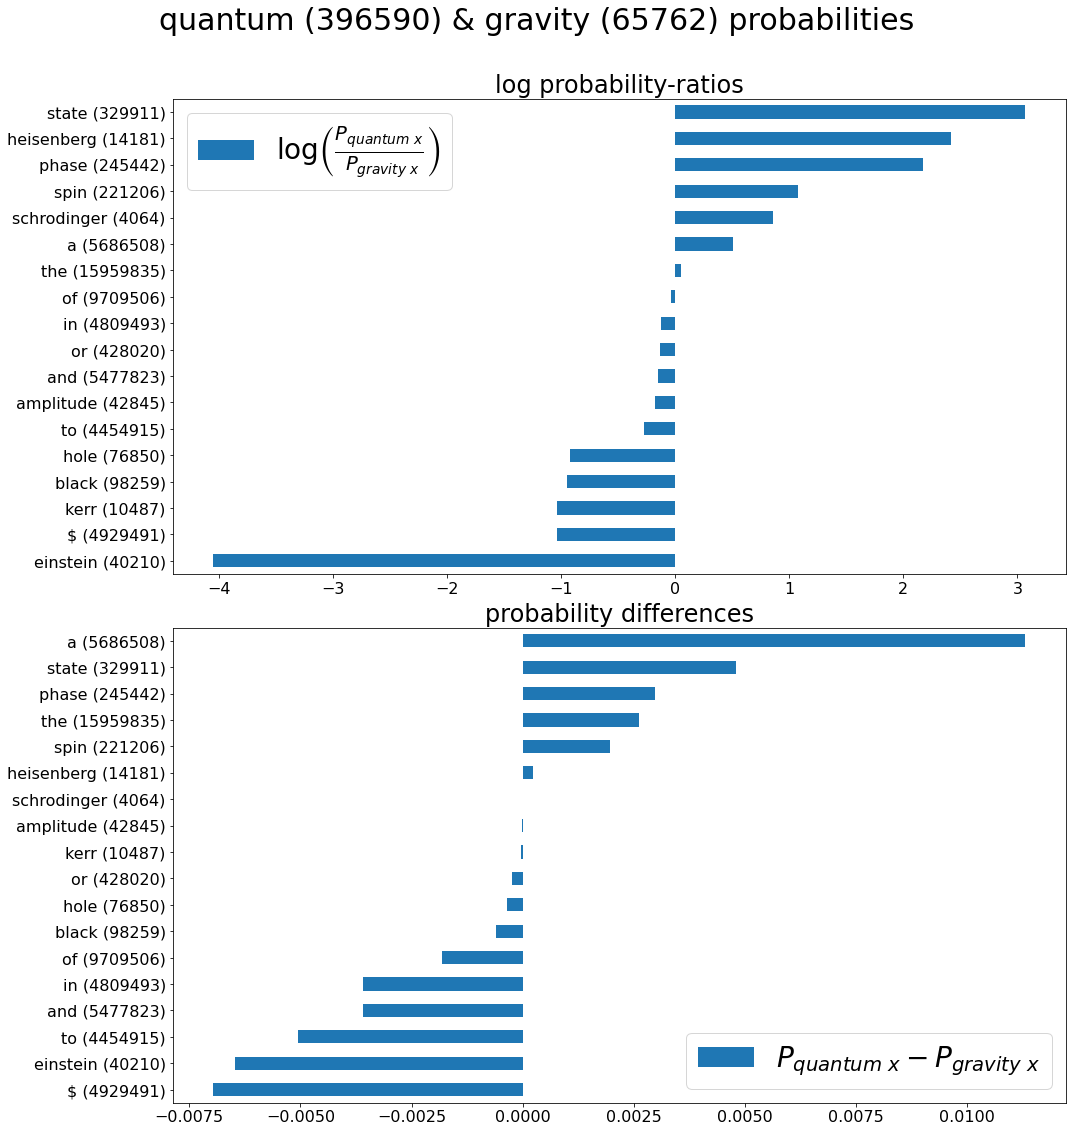

In [ ]:
aux_words = ('of',
             'state',
             'and',
             'the', 
             'a',
             'in',
             'to',
             '$',
             'or',
             'einstein',
             'heisenberg',
             'kerr',
             'schrodinger',
             'hole',
             'amplitude',
             'phase', 
             'black',
             'spin')
log_prob_ratios_plotter(balanced_title_cooccurrence_matrix,
                        'quantum',
                        'gravity',
                        aux_words=aux_words,
                        tokens_df=abstract_tokens_df,
                        suptitle=True,
                        save_path=FOLDERNAME + '/figures/quantum_gravity_probs_plot_abstracts_title_encoded.svg'
                        )

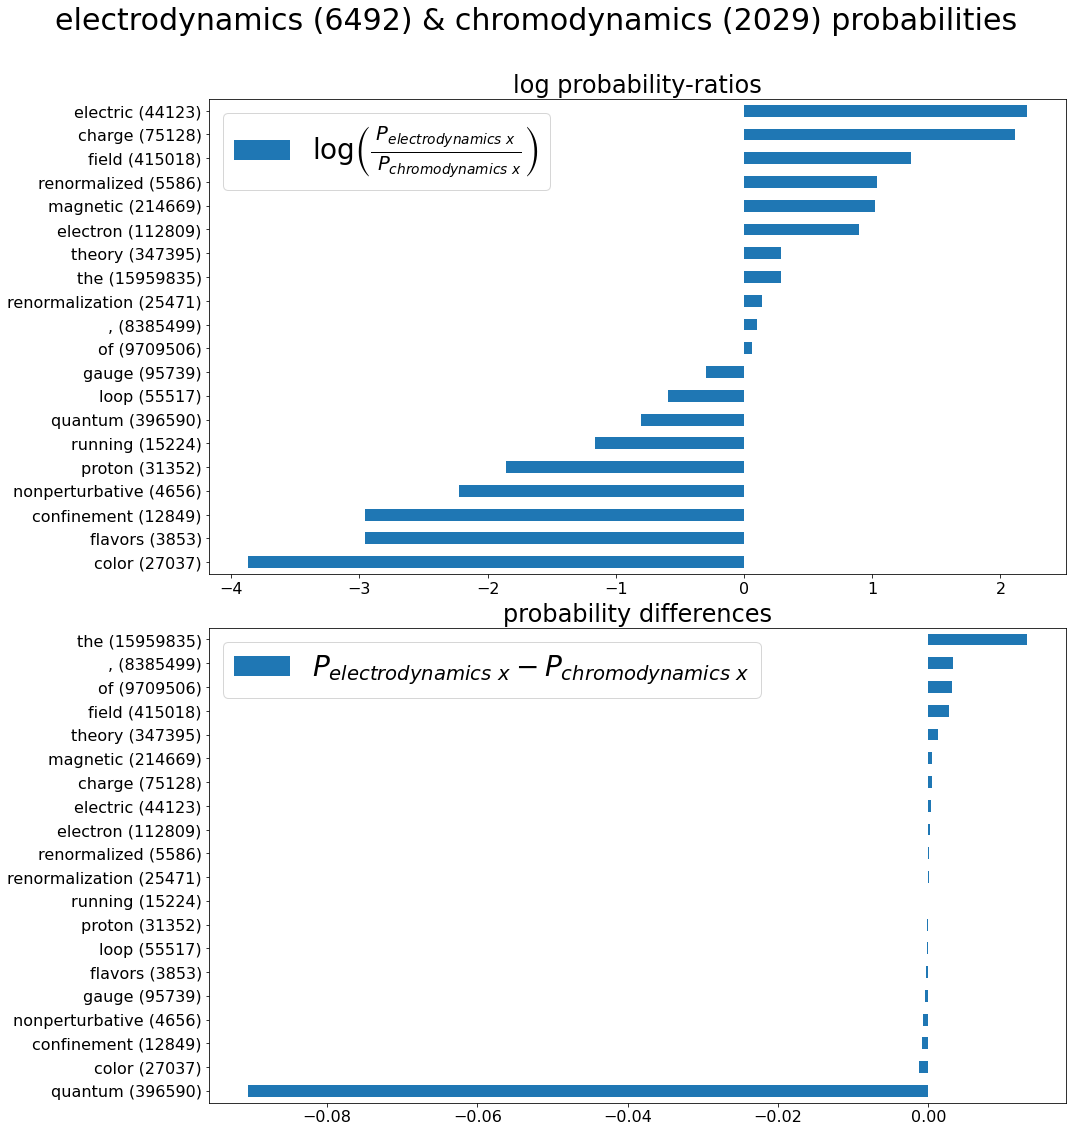

In [ ]:
aux_words = ('color',
             'quantum',
             'theory',
             'charge',
             'electric',
             'magnetic',
             'nonperturbative',
             'field',
             'proton',
             'electron',
             'loop',
             'running',
             'renormalized',
             'confinement',
             'the',
             'of',
             ',',
             'gauge',
             'flavors',
             'renormalization',
             )
log_prob_ratios_plotter(balanced_title_cooccurrence_matrix,
                        'electrodynamics',
                        'chromodynamics',
                        aux_words=aux_words,
                        tokens_df=abstract_tokens_df,
                        suptitle=True,
                        save_path=FOLDERNAME + '/figures/electro_chromo_probs_plot_abstracts_title_encoded.svg'
                        )